## StyleGan Encoding for Children's Drawings

- Using NVIDIA StyleGan: https://github.com/NVlabs/stylegan
- Fine-tuning code: 
- Encoding code: https://github.com/Puzer/stylegan-encoder
  - GOT https://github.com/iyaja/stylegan-encoder

Assumes you have already done this setup and training [stylegan-finetune.ipynb](stylegan-finetune.ipynb)

In [16]:
# paths
src_dir = "../data/square/"
generated_images_dir = "../data/generated_images/"
dlatent_dir = "../data/latent_representations/"

# training params
batch_size = 1

# perceptual model params
image_size = 256
# image_size = 512
lr = 1.0
# lr = 4.0
# iterations = 500
# iterations = 1000
# iterations = 5000
# iterations = 8000
iterations = 10000
# iterations = 20000

# generator params
randomize_noise = False#True

In [17]:
ref_images = [os.path.join(src_dir, x) for x in os.listdir(src_dir)]
ref_images = list(filter(os.path.isfile, ref_images))

if len(ref_images) == 0:
    raise Exception('%s is empty' % src_dir)

os.makedirs(generated_images_dir, exist_ok=True)
os.makedirs(dlatent_dir, exist_ok=True)

In [18]:
# URL_FFHQ = 'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ' # karras2019stylegan-ffhq-1024x1024.pkl
# URL_FFHQ = 'https://s3-us-west-2.amazonaws.com/nanonets/blogs/karras2019stylegan-ffhq-1024x1024.pkl'


# Initialize generator and perceptual model
tflib.init_tf()

# Flicker HQ not what I want
# with dnnlib.util.open_url(URL_FFHQ, cache_dir=config.cache_dir) as f:
#     generator_network, discriminator_network, Gs_network = pickle.load(f)

# Use my finetuned children's drawings stylegan
model = "../stylegan/results/00021-sgan-custom-2gpu/network-snapshot-011545.pkl"
with open(model, 'rb') as f:
#     _G, _D, Gs = pickle.load(f)
    _G, _D, Gs_network = pickle.load(f)

vgg_layer = 8
# vgg_layer = 9

    
generator = Generator(Gs_network, batch_size, randomize_noise=randomize_noise)
perceptual_model = PerceptualModel(image_size, layer=vgg_layer, batch_size=batch_size)
perceptual_model.build_perceptual_model(generator.generated_image)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





In [ ]:
# %%capture

# Optimize (only) dlatents by minimizing perceptual loss between reference and generated images in feature space
for images_batch in tqdm(split_to_batches(ref_images, batch_size), total=len(ref_images)//batch_size):
    names = [os.path.splitext(os.path.basename(x))[0] for x in images_batch]

    perceptual_model.set_reference_images(images_batch)
    op = perceptual_model.optimize(generator.dlatent_variable, iterations=iterations, learning_rate=lr)

    pbar = tqdm(op, leave=False, total=iterations)
    for loss in pbar:
        pbar.set_description(' '.join(names)+' Loss: %.2f' % loss)
    print(' '.join(names), ' loss:', loss)

    # Generate images from found dlatents and save them
    generated_images = generator.generate_images()
    generated_dlatents = generator.get_dlatents()
    for img_array, dlatent, img_name in zip(generated_images, generated_dlatents, names):
        img = PIL.Image.fromarray(img_array, 'RGB')
        img.save(os.path.join(generated_images_dir, f'{img_name}_{lr}_{iterations}.png'), 'PNG')
        np.save(os.path.join(generated_images_dir, f'{img_name}_{lr}_{iterations}.npy'), dlatent)
        np.savetxt(os.path.join(generated_images_dir, f'{img_name}_{lr}_{iterations}.txt'), dlatent, delimiter=',')
#         print(dlatent.shape, dlatent)

    generator.reset_dlatents()


to_encode_original_jasper_marker_bw.jpg_7051fc42-627a-4bca-ba0f-b4e495ddd17f  loss: 2.1590502


## Generate variants near a reconstructed D-Latent

In [1]:
cd stylegan-encoder

/home/jovyan/child-art/stylegan-encoder


In [2]:
pwd

'/home/jovyan/child-art/stylegan-encoder'

In [21]:
import os
import argparse
import pickle
from tqdm import tqdm_notebook as tqdm
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np
import dnnlib
import dnnlib.tflib as tflib
import config
from encoder.generator_model import Generator
from encoder.perceptual_model import PerceptualModel

In [4]:
# Initialize generator and perceptual model
tflib.init_tf()

# Use my finetuned children's drawings stylegan
model = "../stylegan/results/00021-sgan-custom-2gpu/network-snapshot-011545.pkl"
with open(model, 'rb') as f:
    _G, _D, Gs_network = pickle.load(f)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
# generating params
batch_size = 1
randomize_noise = False

generator = Generator(Gs_network, batch_size, randomize_noise=randomize_noise)

### Load a saved DLatent

In [18]:
datapath = "../data/generated_images/"
file = "to_encode_original_jasper_marker_bw.jpg_7051fc42-627a-4bca-ba0f-b4e495ddd17f_1.0_5000.npy"

# latent in embedded space
dlatent = np.load(datapath+file)
dlatent.shape

(16, 512)

In [31]:
def generate_image(latent_vector):
    latent_vector = latent_vector.reshape((1, 16, 512))
    generator.set_dlatents(latent_vector)
    img_array = generator.generate_images()[0]
    img = PIL.Image.fromarray(img_array, 'RGB')
    return img.resize((512, 692))
#     return img

In [ ]:
img = generate_image(dlatent)
scale = 8.0
num_images = 1
plt.figure(figsize=(scale*num_images*1.33, scale), frameon = False)
plt.axis('off')
plt.imshow(img, aspect='auto')
plt.tight_layout()

add a random direction

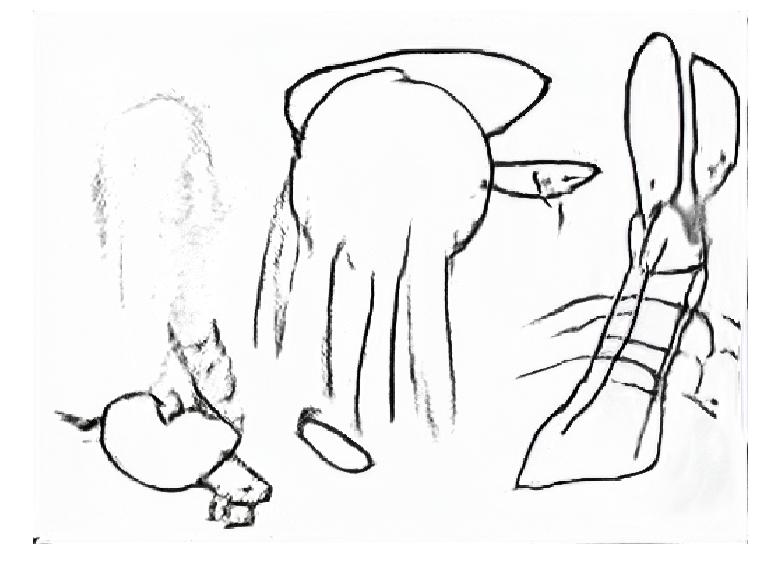

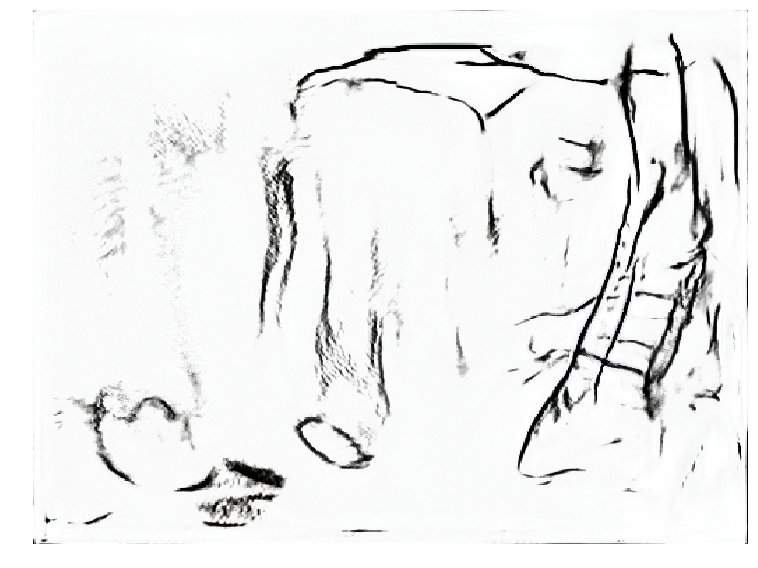

In [68]:
# rand_direction = np.random.RandomState(int(1000*random.random())).randn(num_images, *Gs.input_shapes[0][1:])


coeff = 0.7
# coeff = 1.5
# coeff = 2.5

rand_direction = np.random.randn(batch_size, 16, 512)
# print(rand_direction.shape, dlatent.shape)

new_dlatent = dlatent.copy()
# new_latent_vector[:8] = (dlatent + coeff*direction)[:8]
new_dlatent[:8] = (dlatent + coeff*rand_direction[0])[:8]
# new_dlatent[:4] = (dlatent + coeff*rand_direction[0])[:4]
# new_dlatent[-4:] = (dlatent + coeff*rand_direction[0])[-4:]
# new_dlatent = (dlatent + coeff*rand_direction[0])

scale = 8.0
num_images = 1

old_img = generate_image(dlatent)
plt.figure(figsize=(scale*num_images*1.33, scale), frameon = False)
plt.axis('off')
plt.imshow(old_img, aspect='auto')
plt.tight_layout()


img = generate_image(new_dlatent)
plt.figure(figsize=(scale*num_images*1.33, scale), frameon = False)
plt.axis('off')
plt.imshow(img, aspect='auto')
plt.tight_layout()
# plt.savefig('sgan_sample.png')
    